In [3]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
sns.set(style="whitegrid")
sns.set_color_codes('pastel')

/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [128]:
raw_listings = pd.read_csv('../data/listings.csv')

In [129]:
raw_listings.shape

(63863, 53)

In [130]:
def convert_pub_date(listings):
    # Get datetime of when the scraper ran.
    listings_no_today = listings[~listings.pub_date.str.contains('am')]
    today = pd.to_datetime(listings_no_today.pub_date).max()
    # Set strings with format '8:35 am' to scraper run date.
    has_am = raw_listings.pub_date.str.contains('am')
    listings.loc[has_am, 'pub_date'] = today
    # Convert pub date to datetime.
    listings.loc[:,'pub_date'] = pd.to_datetime(listings['pub_date'])
    return listings

In [131]:
def clean_listings(listings):
    # Coerce price strings to floats.
    listings['price'] = listings.price.str.replace(',','').astype(float).copy()
    # Remove outliters
    listings = listings[(listings.price < 500000)]
    # Convert pub_date and mod_date to datetimes.
    listings = convert_pub_date(listings)
    #listings.loc[:,'mod_date'] = pd.to_datetime(listings['mod_date'])
    # Remove blank notes.
    has_dash = (listings.notes == '-')
    listings.loc[has_dash, 'notes'] = np.NaN
    # Make time variables.
    listings['year'] = listings.pub_date.dt.year.astype(str)
    listings['month'] = listings.pub_date.dt.month.astype(str)
    listings['day_of_week'] = listings.pub_date.dt.dayofweek.astype(str)
    # Make location variables.
    has_location = ~listings.location.isnull()
    listings['city'] = listings[has_location].location.apply(lambda v: str(v).split(', ')[-1])
    listings['neighborhood'] = listings[has_location].location.apply(lambda v: str(v).split(', ')[-2].split('en ')[-1])
    return listings

In [132]:
listings = clean_listings(raw_listings)

/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [133]:
listings.dtypes

azotea compartida                  bool
balcon                             bool
modified                           bool
corriente 220V                     bool
sala-comedor                       bool
other_info                       object
cocina                             bool
piscina                            bool
location                         object
agua las 24 horas                  bool
near_to                          object
garaje                             bool
gas de balon                       bool
independiente                      bool
patio                              bool
contact_name                     object
tanque instalado                   bool
bajos                              bool
telefono                           bool
placa libre                        bool
posibilidad de garaje              bool
pasillo                            bool
corriente 110V                     bool
interior                           bool
meters_squared                  float64


## How many properties have been listed over time?

In [9]:
listings_dt = listings.set_index(listings.pub_date)

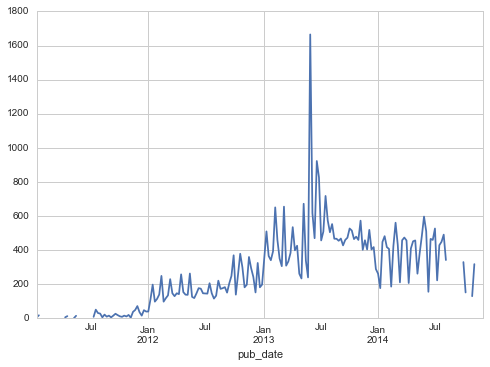

In [10]:
listings_dt['count'] = 1
listings_dt['count'].resample('W', how='sum').plot()

## How have prices changed over time?

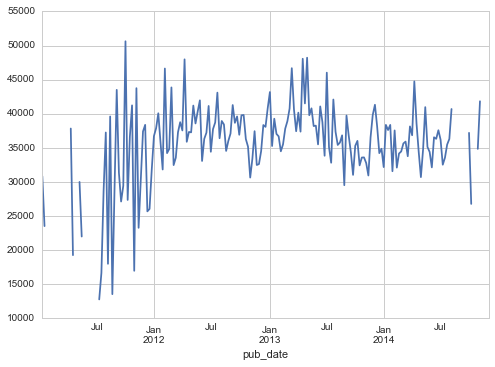

In [11]:
listings_dt.columns
listings_dt['price'].resample('W', how='mean').plot()

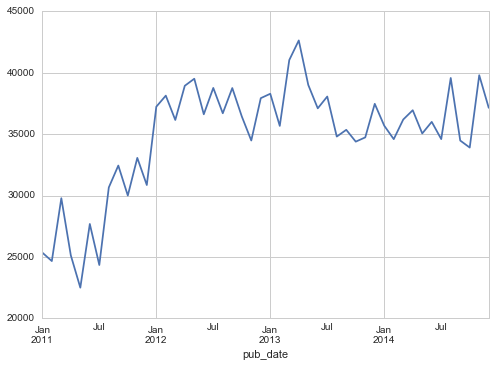

In [12]:
listings_dt['price'].resample('M', how='mean').plot()

## How does the size of a home affect it's price?

In [10]:
#home_or_apt = (listings.property_type == 'Casa') | (listings.property_type == 'Apartamento')
#listings_home_apt = listings[home_or_apt]
# NOTE: 8510 listings have meters_squared values, 7730 are less than 500
has_meters = ~listings.meters_squared.isnull()
meters_lt_500 = listings.meters_squared < 500
listings_with_meters = listings[has_meters & meters_lt_500]
listings_with_meters.shape[0]

7730

/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


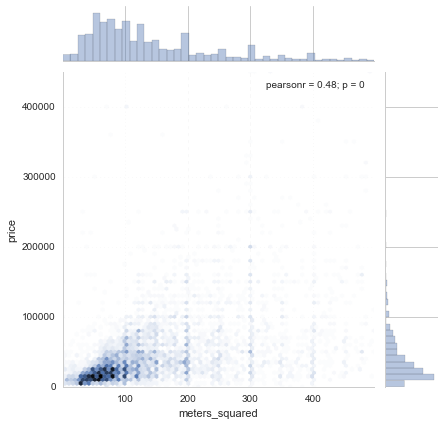

In [11]:
sns.jointplot('meters_squared', 'price', listings_with_meters, kind='hex')

In [12]:
listings[has_meters].shape

(8510, 53)

In [13]:
listings[has_meters & meters_lt_500].shape

(7730, 53)

(0, 500000)

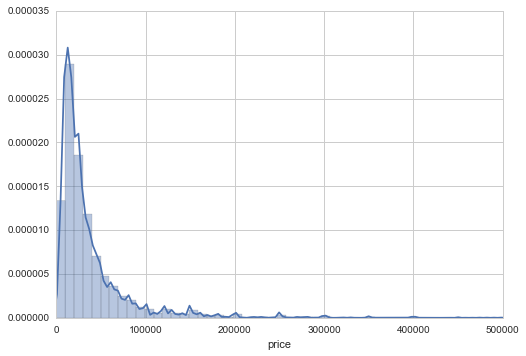

In [137]:
sns.distplot(listings.price)
plt.xlim((0,500000))

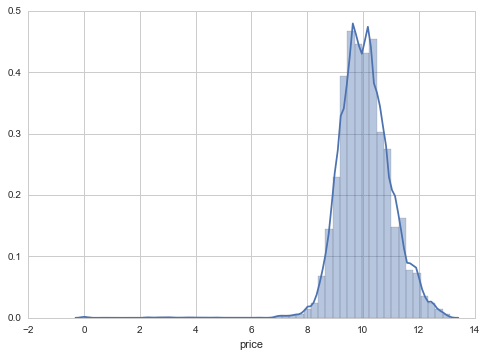

In [138]:
sns.distplot(np.log(listings.price))

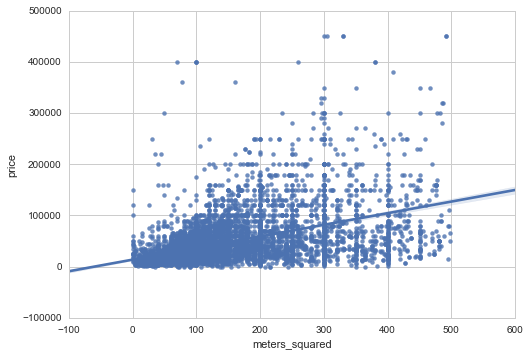

In [18]:
sns.regplot('meters_squared', 'price', listings_with_meters)

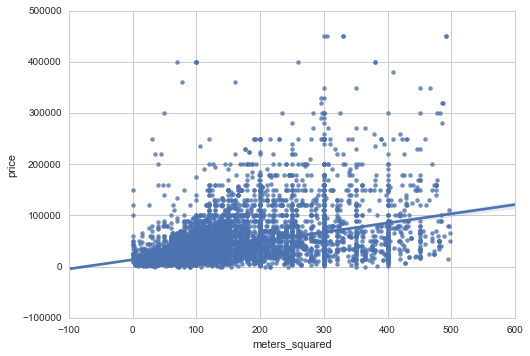

In [19]:
sns.regplot('meters_squared', 'price', listings_with_meters, robust=True)

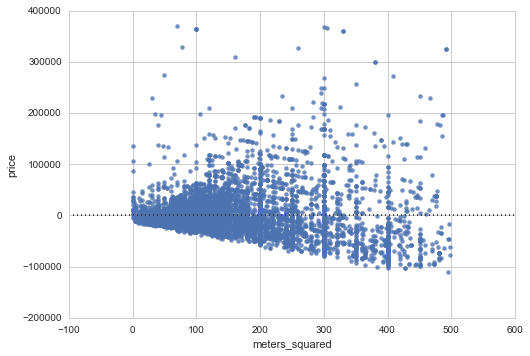

In [20]:
sns.residplot('meters_squared', 'price', listings_with_meters)

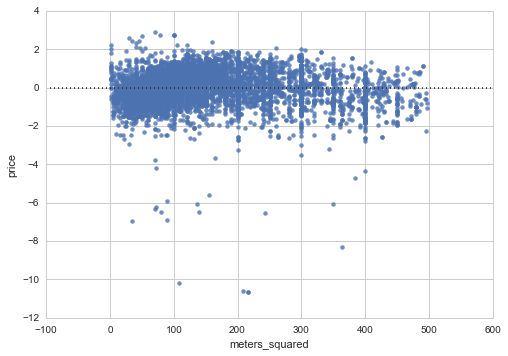

In [28]:
sns.residplot('meters_squared', np.log(listings_with_meters.price), listings_with_meters)

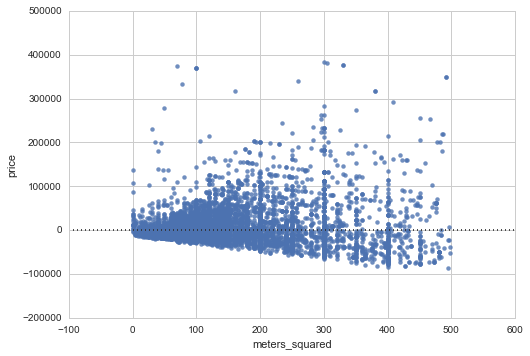

In [21]:
sns.residplot('meters_squared', 'price', listings_with_meters, robust=True)

## How many homes have been listing, vs apartments?

/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


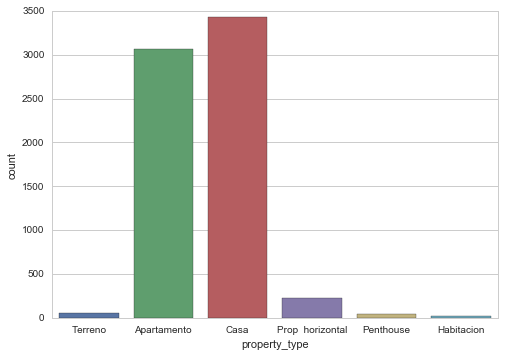

In [238]:
sns.countplot(listings.property_type)

## What's the distribution of rooms overall?

/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


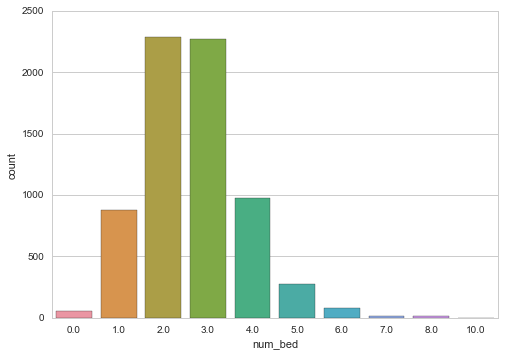

In [253]:
sns.countplot(listings.num_bed.apply(np.floor).sort_values())

/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


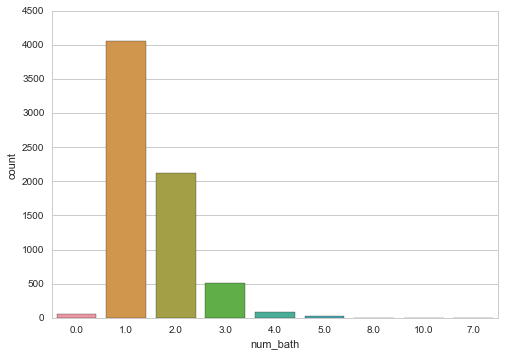

In [254]:
sns.countplot(listings.num_bath)

## What's the distribution of rooms by property type?

The vast majority are homes or apartments.

/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


AttributeError: max must be larger than min in range parameter.

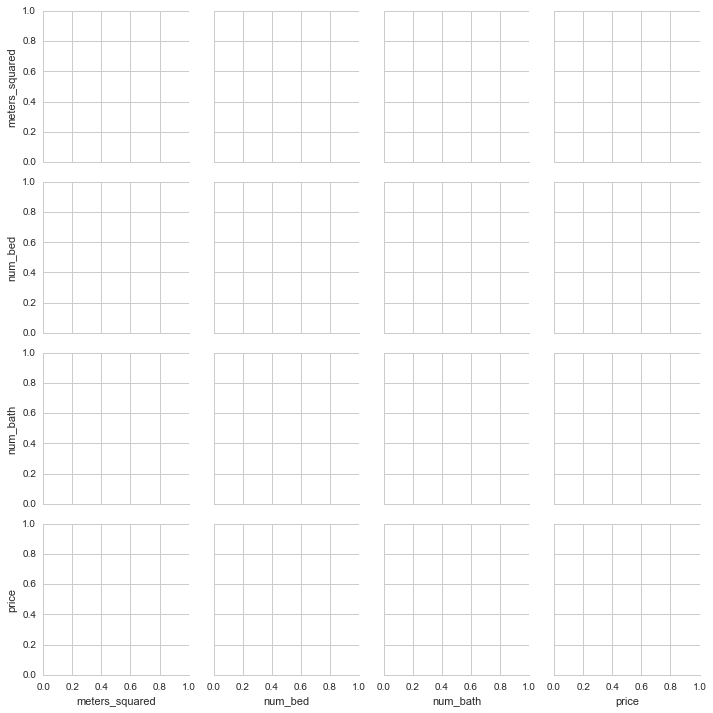

In [140]:
numerical_vars = ['meters_squared', 'num_bed', 'num_bath', 'price']
listings_home_apt = listings[(listings.property_type == 'Casa') | (listings.property_type == 'Apartamento')]
sns.pairplot(listings_home_apt, vars=numerical_vars, hue='property_type')

## How do prices vary by property type?

/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


(0, 250000)

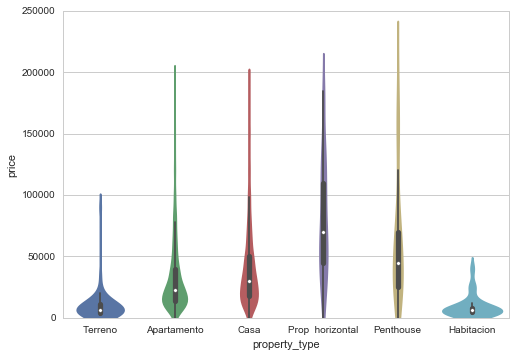

In [225]:
sns.violinplot(x=listings.property_type, y=listings.price)
plt.ylim((0,250000))

/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


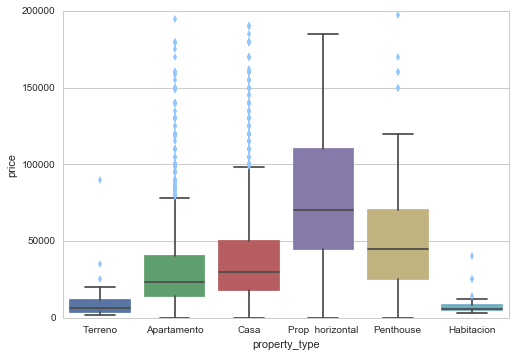

In [240]:
sns.boxplot(x=listings.property_type, y=listings.price)

/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


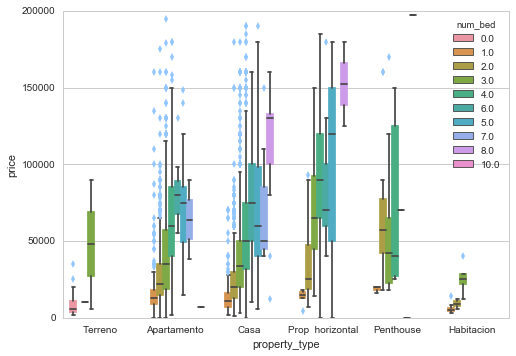

In [246]:
sns.boxplot(x=listings.property_type, hue=listings.num_bed.apply(np.floor), y=listings.price)

Houses have a higher mean and a heavier tail than apartments.
Penthouses cost more, and entire buildings the most.
Rooms and lots cost a lost less.

## How do prices vary by room?

In [229]:
listings.columns

Index(['azotea compartida', 'balcon', 'modified', 'corriente 220V',
       'sala-comedor', 'other_info', 'cocina', 'piscina', 'location',
       'agua las 24 horas', 'near_to', 'garaje', 'gas de balon',
       'independiente', 'patio', 'contact_name', 'tanque instalado', 'bajos',
       'telefono', 'placa libre', 'posibilidad de garaje', 'pasillo',
       'corriente 110V', 'interior', 'meters_squared', 'puntal alto',
       'num_bed', 'elevador', 'construction_era', 'num_bath', 'id',
       'azotea libre', 'terraza', 'mobile_number', 'price', 'patinejo',
       'puerta calle', 'pub_date', 'phone_number', 'portal', 'gas de la calle',
       'cocina-comedor', 'hall', 'altos', 'property_type', 'saleta', 'comedor',
       'barbacoa', 'jardin', 'notes', 'carposhe', 'sala', 'mod_date'],
      dtype='object')

/Users/jpvelez/anaconda/envs/cubisima/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


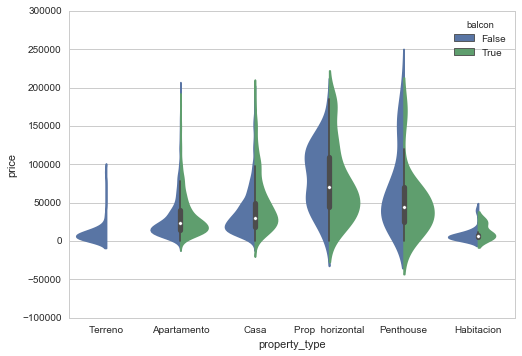

In [236]:
sns.violinplot(x=listings.property_type, hue=listings['balcon'], y=listings.price, split=True)

## Regression

In [114]:
listings.columns

Index(['azotea compartida', 'balcon', 'modified', 'corriente 220V',
       'sala-comedor', 'other_info', 'cocina', 'piscina', 'location',
       'agua las 24 horas', 'near_to', 'garaje', 'gas de balon',
       'independiente', 'patio', 'contact_name', 'tanque instalado', 'bajos',
       'telefono', 'placa libre', 'posibilidad de garaje', 'pasillo',
       'corriente 110V', 'interior', 'meters_squared', 'puntal alto',
       'num_bed', 'elevador', 'construction_era', 'num_bath', 'id',
       'azotea libre', 'terraza', 'mobile_number', 'price', 'patinejo',
       'puerta calle', 'pub_date', 'phone_number', 'portal', 'gas de la calle',
       'cocina-comedor', 'hall', 'altos', 'property_type', 'saleta', 'comedor',
       'barbacoa', 'jardin', 'notes', 'carposhe', 'sala', 'mod_date', 'city',
       'neighborhood'],
      dtype='object')

In [134]:
# TODO: move to cleaning function
# TODO: make time and location features.
columns = listings.columns.values.tolist()
cols_rename = dict([(col, col.replace(' ', '_')) for col in columns])

drop_cols = ['price', 'near_to', 'construction_era', 'mod_date', 'meters_squared', 'pub_date',
             'other_info', 'mobile_number', 'phone_number', 'contact_name', 'notes', 'location']
listings_clean = listings.rename(columns=cols_rename)
X_cols = listings_clean.drop(drop_cols, axis=1).columns.values.tolist()
X_cols_formula =' + '.join(X_cols)
y, X = dmatrices('price ~ %s' % X_cols_formula, data=listings_clean, return_type='dataframe')

In [116]:
X.shape

(50063, 204)

In [49]:
((1 - (listings.isnull().sum() / listings.shape[0])) * 100).sort_values()

near_to                    2.695044
construction_era           5.721023
mod_date                   6.240216
meters_squared            16.863841
other_info                21.227434
mobile_number             43.768702
phone_number              75.693082
contact_name              86.156194
notes                     92.663932
location                  99.207340
id                       100.000000
azotea libre             100.000000
terraza                  100.000000
price                    100.000000
patinejo                 100.000000
puerta calle             100.000000
pub_date                 100.000000
jardin                   100.000000
num_bath                 100.000000
cocina-comedor           100.000000
hall                     100.000000
altos                    100.000000
carposhe                 100.000000
property_type            100.000000
saleta                   100.000000
comedor                  100.000000
barbacoa                 100.000000
portal                   100

In [37]:
# NO LOCATION OR TIME VARS
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     979.1
Date:                Fri, 29 Jan 2016   Prob (F-statistic):               0.00
Time:                        13:42:13   Log-Likelihood:            -5.9586e+05
No. Observations:               50463   AIC:                         1.192e+06
Df Residuals:                   50419   BIC:                         1.192e+06
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------
Interc

In [117]:
# LOCATION VARS
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     283.5
Date:                Fri, 29 Jan 2016   Prob (F-statistic):               0.00
Time:                        14:51:19   Log-Likelihood:            -5.8759e+05
No. Observations:               50063   AIC:                         1.176e+06
Df Residuals:                   49866   BIC:                         1.177e+06
Df Model:                         196                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------

In [135]:
# LOCATION AND TIME VARS
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     257.9
Date:                Fri, 29 Jan 2016   Prob (F-statistic):               0.00
Time:                        14:57:30   Log-Likelihood:            -5.8755e+05
No. Observations:               50063   AIC:                         1.176e+06
Df Residuals:                   49846   BIC:                         1.177e+06
Df Model:                         216                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------

In [38]:
model = sm.OLS(np.log(y), X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     889.7
Date:                Fri, 29 Jan 2016   Prob (F-statistic):               0.00
Time:                        13:42:18   Log-Likelihood:                -54118.
No. Observations:               50463   AIC:                         1.083e+05
Df Residuals:                   50419   BIC:                         1.087e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------
Interc

In [52]:
rlm_model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
results = rlm_model.fit()
print(results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                  price   No. Observations:                50463
Model:                            RLM   Df Residuals:                    50419
Method:                          IRLS   Df Model:                           43
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 29 Jan 2016                                         
Time:                        13:16:48                                         
No. Iterations:                    15                                         
                                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------
Interc

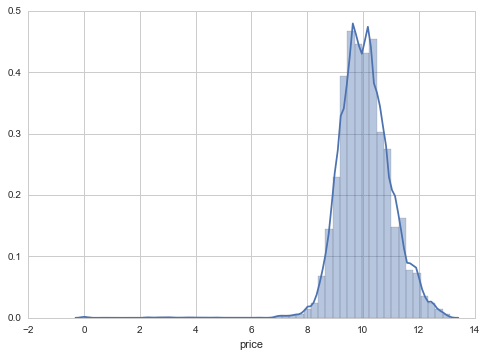

In [33]:
sns.distplot(np.log(listings.price))